In [1]:
train_path = "./dataset/train.csv"
test_path = "./dataset/test.csv"

accuracy_path = "./data/accuracy.pkl"
loss_path = "./data/loss.pkl"
model_state_path = "./output/mnist_model.pth"

sample_submission_path = "./dataset/sample_submission.csv"
output_submission_path = "./output/submission.csv"

In [2]:
import numpy as np
import torch
import os
import torch.multiprocessing as mp
import train
import pandas as pd
                
max_epochs = 5
gpu_count = 2

In [3]:
os.environ["MASTER_ADDR"] = "127.0.0.1"
os.environ["MASTER_PORT"] = "8888"

In [4]:
%%time
mp.spawn(train.train, nprocs=gpu_count, args=(train_path, model_state_path, accuracy_path, loss_path, gpu_count,max_epochs,))   

Epoch: 1
Loader: train, accuracy 0.7938690476190476, loss: 1.9170912824925923
Loader: valid, accuracy 0.9533333333333334, loss: 0.15048423519840948
Epoch: 2
Loader: train, accuracy 0.9657142857142857, loss: 0.10940916878836496
Loader: valid, accuracy 0.9704761904761905, loss: 0.09331520702000018
Epoch: 3
Loader: train, accuracy 0.9793452380952381, loss: 0.06876193399408034
Loader: valid, accuracy 0.9769047619047619, loss: 0.0693650049743829
Epoch: 4
Loader: train, accuracy 0.9839285714285714, loss: 0.05161468441642466
Loader: valid, accuracy 0.9807142857142858, loss: 0.05850786714021255
Epoch: 5
Loader: train, accuracy 0.9874404761904761, loss: 0.040605662026930424
Loader: valid, accuracy 0.9835714285714285, loss: 0.05195270744324834
CPU times: user 6.03 ms, sys: 1.02 ms, total: 7.05 ms
Wall time: 24.8 s


Text(0.5, 0, 'epoch')

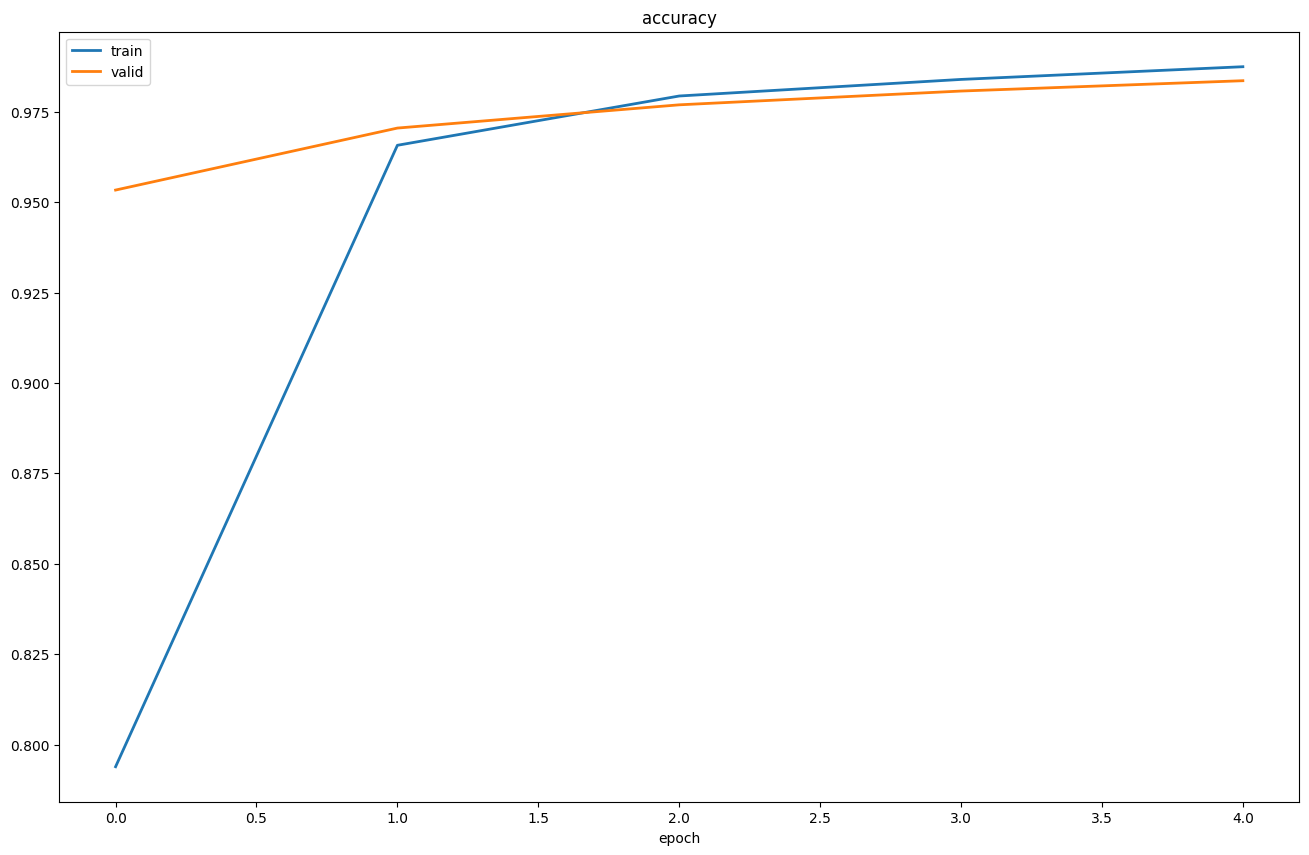

In [5]:
from matplotlib import pyplot as plt
import pickle

with open(accuracy_path, 'rb') as f:
    accuracy = pickle.load(f)
    
plt.figure(figsize=(16, 10))
plt.title("accuracy")
plt.plot(np.arange(max_epochs), accuracy['train'], label='train', linewidth=2)
plt.plot(np.arange(max_epochs), accuracy['valid'], label='valid', linewidth=2)
plt.legend()
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

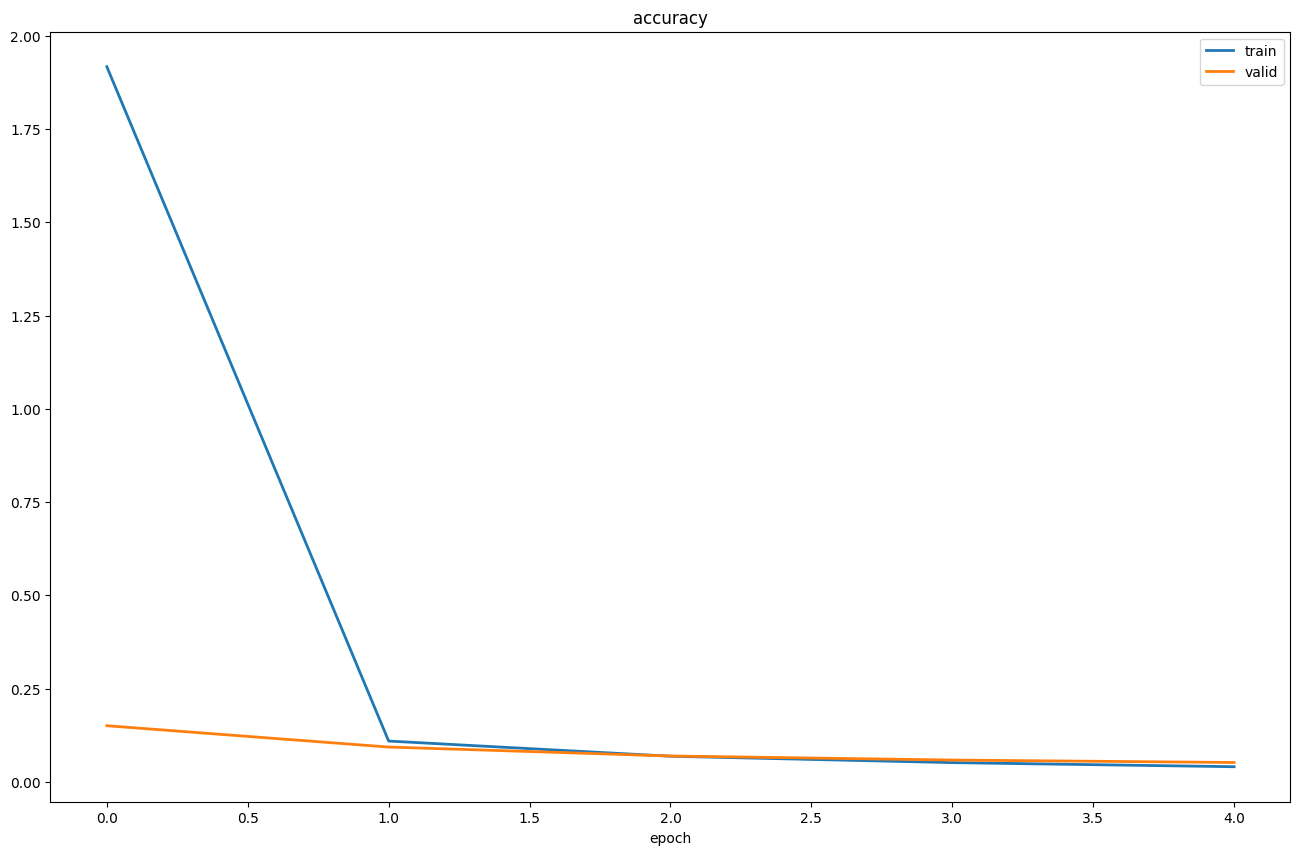

In [6]:
with open(loss_path, 'rb') as f:
    losses = pickle.load(f)
    
plt.figure(figsize=(16, 10))
plt.title("accuracy")
plt.plot(np.arange(max_epochs), losses['train'], label='train', linewidth=2)
plt.plot(np.arange(max_epochs), losses['valid'], label='valid', linewidth=2)
plt.legend()
plt.xlabel('epoch')

In [7]:
test_data = pd.read_csv(test_path)
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
from dataset import TestDataset
from transforms import data_tfs

test_dataset = TestDataset(test_data.to_numpy().astype(np.float32), transform=data_tfs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [9]:
from net import MnistNet

model = MnistNet()
model.load_state_dict(torch.load(model_state_path))

result = []

model.eval()
for x_batch in test_loader:
    with torch.no_grad():
        outp = model(x_batch)
        preds = outp.argmax(1)
        result += preds.tolist()

In [10]:
submission = pd.read_csv(sample_submission_path)
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [11]:
submission['Label'] = result
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [12]:
submission.to_csv(output_submission_path, index=None)